SOM Testing Script
==================

Checks that install is valid and works, first with a toy example, then with a subset of testing data

Toy Example:
------------

In [1]:
import numpy as np
import somoclu
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Make testing data
c1 = np.random.rand(50, 3)/5
c2 = (0.6, 0.1, 0.05) + np.random.rand(50, 3)/5
c3 = (0.4, 0.1, 0.7) + np.random.rand(50, 3)/5
data = np.float32(np.concatenate((c1, c2, c3)))
colors = ["red"] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
n_rows, n_columns = 100, 160

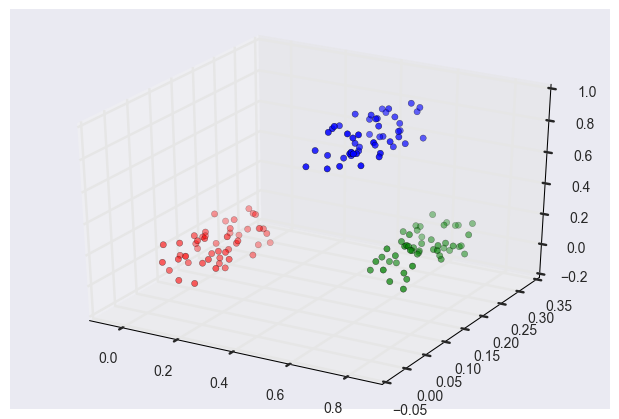

In [4]:
# Plot the testing data
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)
labels = range(150)

In [5]:
# Run SOM
som = somoclu.Somoclu(n_columns, n_rows, data=data, compactsupport=False)
som.train()

Next, testing the verbosity parameter--

These are the numbers that I get on my machine:

    Time for epoch 1: 0.03855      10% [======                                            ]
    Time for epoch 2: 0.04262      20% [===========                                       ]
    Time for epoch 3: 0.04313      30% [================                                  ]
    Time for epoch 4: 0.04807      40% [=====================                             ]
    Time for epoch 5: 0.06775      50% [==========================                        ]
    Time for epoch 6: 0.07957      60% [===============================                   ]
    Time for epoch 7: 0.07437      70% [====================================              ]
    Time for epoch 8: 0.08394      80% [=========================================         ]
    Time for epoch 9: 0.06937      90% [==============================================    ]
    Time for epoch 10: 0.04927     100% [===================================================]

They should (hopefully) be [much] faster on the new box:

In [ ]:
# May require a git clone of somoclu if latest packaged version doesn't include verbosity
som = somoclu.Somoclu(n_columns, n_rows, data=data, compactsupport=False, verbose=2)
som.train()

Sanity checking the default install:
-----------------------------------

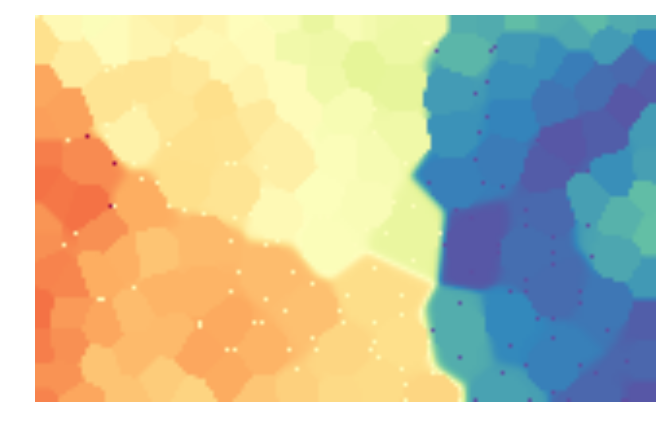

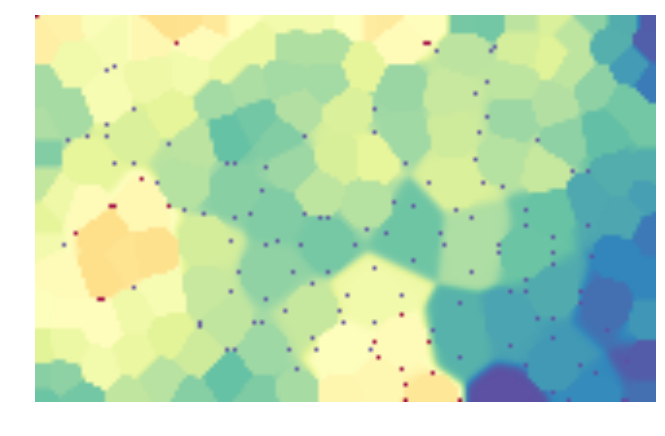

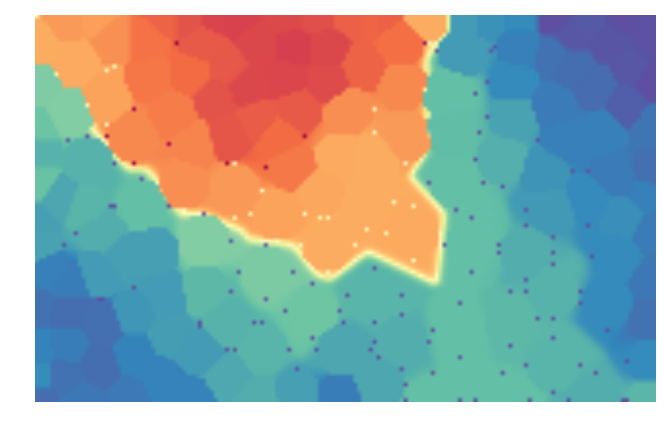

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [6]:
# Reference plot is similar to: https://somoclu.readthedocs.io/en/stable/example.html
som.view_component_planes()

Note, you can also force check the CPU version using:

In [7]:
# kerneltype=0 forces CPU
som = somoclu.Somoclu(n_columns, n_rows, data=data, compactsupport=False, kerneltype=0)
som.train()

Sanity checking the GPU support
-------------------------------

There is an option to enable GPU usage from the python interface that should be enabled:

https://github.com/peterwittek/somoclu/tree/master/src/Python#build-with-cuda-support-on-linux-and-os-x

From the somoclu documentation (https://github.com/peterwittek/somoclu):

"The maps generated by the GPU and the CPU kernels are likely to be different. For computational efficiency, Somoclu uses single-precision floats. This occasionally results in identical distances between a data instance and the neurons. The CPU version will pick the best matching unit with the lowest coordinate values. Such sequentiality cannot be guaranteed in the reduction kernel of the GPU variant. This is not a bug, but it is better to be aware of it."

...the maps should still look like something though. If the map is black, or doesn't show distinct clusters, then something is wrong on the GPU/CUDA end.

In [ ]:
# kerneltype=1 forces GPU
som = somoclu.Somoclu(n_columns, n_rows, data=data, compactsupport=False, kerneltype=1)
som.train()

In [ ]:
som.view_component_planes()

Intended use of the HPC server
-------------------------------

There are two primary, specific reasons that we are ordering the HPC node. One of them is to cluster image tiles; on production, we'll be running ~250,000 image tiles. Below is code for running 10,000 tiles, and includes the imports and data preprocessing steps that we'd execute on the larger data set. 

In [1]:
# Restarting the kernel

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import somoclu
import os, sys
from tqdm import tqdm
import rasterio

In [4]:
# Fixing plots
rcParams['image.cmap'] = 'viridis'

In [5]:
# We use rasterio to read in the tiles since it's faster, but the following line should also 
# work if we were to import gdal...


#test = gdal.Open('Desktop/all_tiles_april/2cc5efe534a2cbfdac63caefd1d04f7fb43094210f7c4cf2ee355799e2b5c279.tif')

In [6]:
# Index is stored as an hdf file/array in pandas
store = pd.HDFStore('/Users/grigsbye/Desktop/full_wf.h5','r')
conv = store['conv']
store.close()

In [7]:
conv.index[0]

'0000a611a21ce4b4d7a46384354d97ee836d781602a95da52c4d5a4ddd00604e'

In [8]:
# Grab 10k tiles to test on...
data = np.ones((10000,40000),dtype=numpy.float32)
for i in tqdm(range(10000)):
    #temp = gdal.Open('Desktop/all_tiles_april/' + conv.index[i] + '.tif')
    temp = rasterio.open('Desktop/all_tiles_april/' + conv.index[i] + '.tif')
    #tarray = temp.GetRasterBand(1).ReadAsArray()
    data[i,:] = temp.read().ravel()

100%|██████████| 10000/10000 [00:56<00:00, 175.79it/s]


In [9]:
# We are using dct for dimensionality reduction...

In [10]:
from scipy import fftpack
from scipy.fftpack import dct, idct

In [11]:
a = data[3303,:].reshape(200,200)

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')
c = dct2(a)

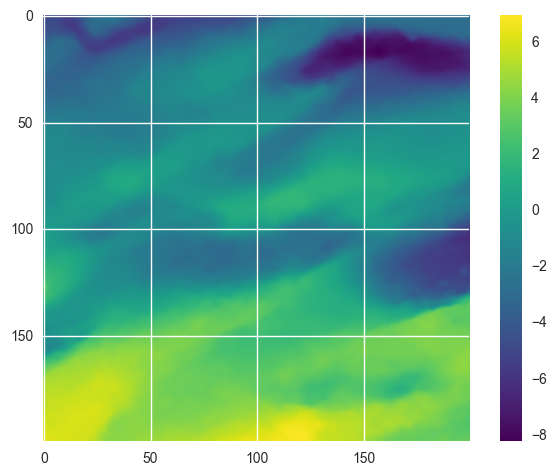

In [12]:
# Full resolution
imshow(a)
colorbar()

In [13]:
%time dct2(a)

CPU times: user 649 µs, sys: 257 µs, total: 906 µs
Wall time: 635 µs


array([[  1.09677566e-02,   6.47954712e+01,  -5.93885994e+01, ...,
         -4.09622211e-03,  -1.78833015e-03,   7.41577183e-04],
       [ -4.93507141e+02,   5.10074997e+00,  -3.92081871e+01, ...,
          3.03649897e-04,   5.90515148e-04,  -1.18387220e-02],
       [  1.01680679e+02,   1.55523071e+01,  -5.55836964e+00, ...,
         -8.23974624e-05,  -7.22560892e-03,   5.57403592e-03],
       ..., 
       [ -1.42676467e-02,  -6.33305777e-03,   1.98057778e-02, ...,
         -5.06806001e-03,   3.66434315e-03,  -1.24512089e-03],
       [ -1.84137840e-02,   1.78737789e-02,   6.84904819e-03, ...,
         -1.03918579e-03,  -1.00022880e-02,   7.04148435e-04],
       [  1.59433521e-02,  -6.70301495e-03,  -1.95543952e-02, ...,
          1.95544655e-03,   3.54829966e-03,  -7.91987404e-04]], dtype=float32)

In [14]:
# dct2 on first 10k tiles...
datafft = np.ones((10000,10000),dtype=numpy.float32) # Reduced dimentionality!!!
for j in tqdm(range(10000)):
    temp2 = dct2(data[j,:].reshape(200,200))
    temp3 = temp2[:100,:100] 
    datafft[j,:10000] = temp3.ravel()

100%|██████████| 10000/10000 [00:04<00:00, 2078.78it/s]


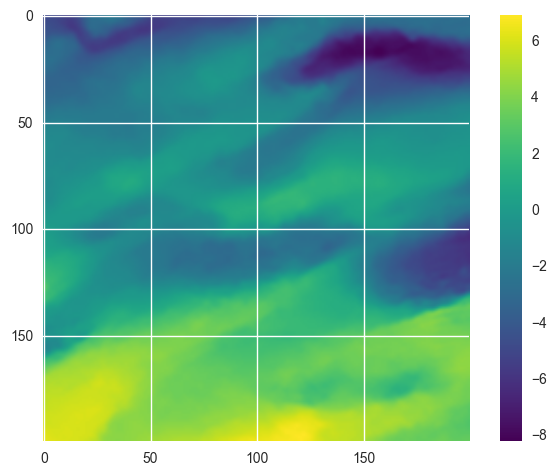

In [15]:
# Compressed image... one quarter the orginal size, but reproduces most detail
temp = np.zeros_like(a)
temp[:100,:100] = np.reshape(datafft[3303,:], (100,100))
imshow(idct2(temp))
colorbar()

...the following command took about 1,000 compute hours on the non-DCT transformed data (i.e., 10 days of run time on quadcore machine running 4 threads). It will take far less on the reduced data set, but still probably around 250 hours. If all 56 threads are operating with no help from the GPU, I'd expect this to take around 4 hours on the new machine, and hopefully less with the GPU acceleration.

In [11]:
n_rows, n_columns = 200, 300
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False,  kerneltype=0, initialization="pca")
som.train(data=data)

In [17]:
# Various sample outputs from after the above completed
# Last set of images are 'similar' and clustered together (i.e., show channels)

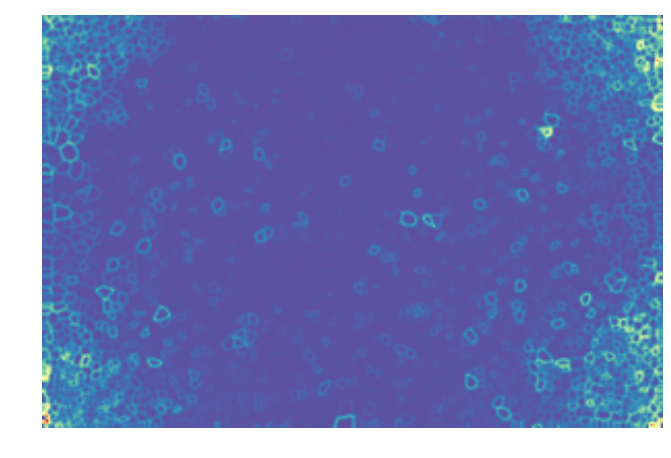

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [16]:
som.view_umatrix()#bestmatches=True)

In [64]:
from scipy import stats

In [69]:
X, Y = np.mgrid[0:301:1, 0:201:1]
positions = np.vstack([X.ravel(), Y.ravel()])
kernel = stats.gaussian_kde(som.bmus.T)
Z = np.reshape(kernel(positions).T, X.shape)

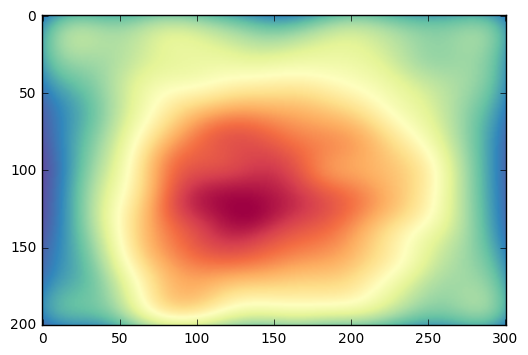

In [73]:
imshow(np.rot90(Z))
#colorbar()

In [30]:
som.bmus[134],som.bmus[1234]

(array([173,  60], dtype=int32), array([278, 198], dtype=int32))

array([241,   1], dtype=int32)

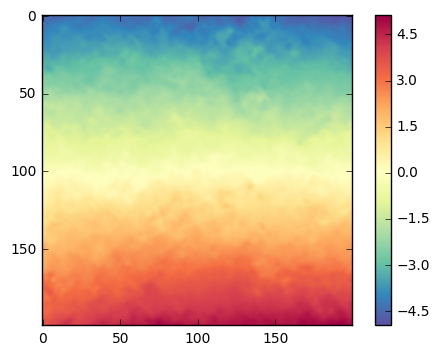

In [105]:
imshow(data[8284,:].reshape(200,200))
colorbar()
som.bmus[8284]

array([245,   0], dtype=int32)

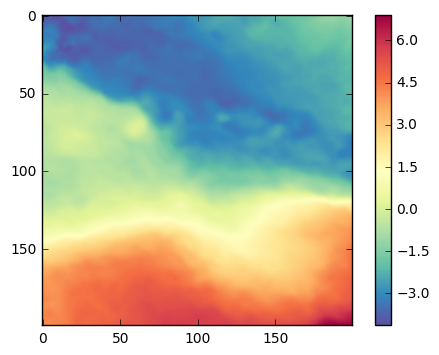

In [101]:
imshow(data[642,:].reshape(200,200))
colorbar()
som.bmus[642] #ref

array([245,   0], dtype=int32)

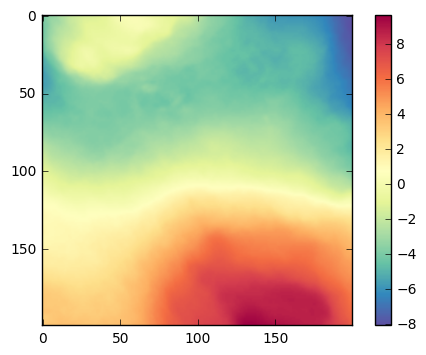

In [165]:
imshow(data[7046,:].reshape(200,200))
colorbar()
som.bmus[642] # Distance 4
# [249,0]

array([245,   0], dtype=int32)

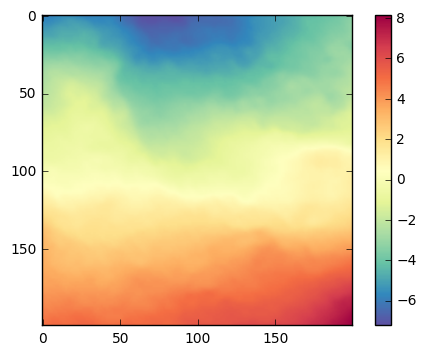

In [163]:
imshow(data[6022,:].reshape(200,200))
colorbar()
som.bmus[642] #distance 2
# [247,0]

array([245,   0], dtype=int32)

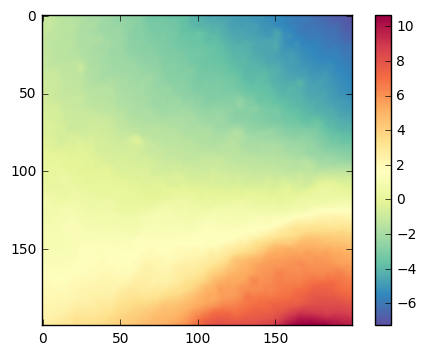

In [164]:
imshow(data[3009,:].reshape(200,200))
colorbar()
som.bmus[642] #distance 3
# [243, 1]

array([245,   0], dtype=int32)

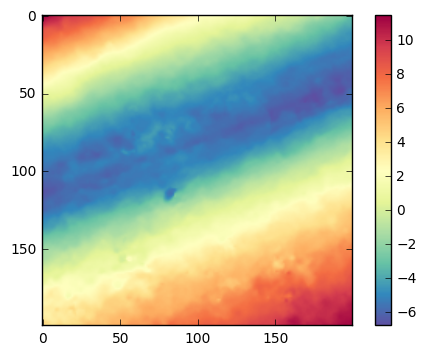

In [171]:
imshow(data[3868,:].reshape(200,200))
colorbar()
som.bmus[642] # Distance 5
# [240, 0]